<h2><b>Sequential Models</h2>

<h4><i>Importing libraries</h4>

In [206]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats
import pymc3 as pm3
import numdifftools as ndt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from filterpy.kalman import ExtendedKalmanFilter
from filterpy.common import Q_discrete_white_noise

%matplotlib inline

<h3><b>1. Least Squares and Cross Validation</h3>

<h4><i>Generate data</h4>

In [207]:
N = 100
sigma2 = 0.2
ϵ = np.random.normal(0, sigma2, N)
#1 ≤ i ≤ N
i = np.arange(1, N+1)
x = 2 *np.pi*(i/N)
y = np.sin(x) + ϵ

data = pd.DataFrame({'x': x, 'y': y})

<AxesSubplot:xlabel='x', ylabel='y'>

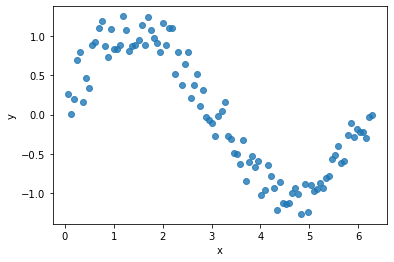

In [208]:
sns.regplot(x='x', y='y', data=data, fit_reg=False)

<h5><i>Ordinary Least Square</h4>

In [209]:
X = sm.add_constant(x)

ols_result = sm.OLS(y,X).fit().summary()

<h4><b>1.4 Maximum Likelihood</h4>

<h5> 1.4.1

In [210]:
def maxlik(params):
  intercept, beta, sd = params[0], params[1], params[2]
  yhat = intercept + beta * x
  l = -np.sum(stats.norm.logpdf(y, loc=yhat, scale=sd))
  return l


In [211]:
initial_guess = np.array([5,5,5]) #random initial guess
results = minimize(maxlik, initial_guess, method = 'Nelder-Mead', options={'disp': True})

Optimization terminated successfully.
         Current function value: 69.783224
         Iterations: 95
         Function evaluations: 178


In [212]:
print(results)

 final_simplex: (array([[ 1.04469013, -0.32511822,  0.48619794],
       [ 1.04471869, -0.32512356,  0.48624153],
       [ 1.04464621, -0.32511916,  0.48621074],
       [ 1.04461601, -0.3251058 ,  0.48620616]]), array([69.78322361, 69.78322381, 69.78322402, 69.78322403]))
           fun: 69.78322360854852
       message: 'Optimization terminated successfully.'
          nfev: 178
           nit: 95
        status: 0
       success: True
             x: array([ 1.04469013, -0.32511822,  0.48619794])


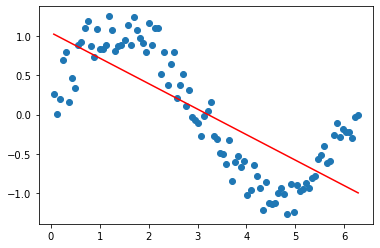

In [213]:
plt.plot(x, y, 'o')
plt.plot(x, results.x[0] + results.x[1] * x, 'r-')
plt.show()


<h5> 1.4.2

In [214]:
#print const from ols   
print('Least square: ', ols_result.tables[1][1][1])


#show maximum likelihood
print('Maximum likelihood:', np.round(results.final_simplex[0][1][0], 4))


Least square:      1.0447
Maximum likelihood: 1.0447


<h5> 1.4.3

In [215]:
def radial(x, xi, r):
    return np.exp(-((x-xi)**2)/r**2)


In [216]:

def likelihood(params, x, y):
    y_hat = radial(x, params[0], params[1])
    return np.sum(stats.norm.logpdf(y, loc=y_hat, scale=1))

In [217]:
r = [0.1, 0.15, 0.5, 1]

for i in r:
    print('r = ', i, 'likelihood = ', likelihood([0, i], x, y))



r =  0.1 likelihood =  -121.17000435490135
r =  0.15 likelihood =  -121.2857781330469
r =  0.5 likelihood =  -120.51645547880068
r =  1 likelihood =  -117.11682087057324


<h4><b>1.5 Regularized Least Square</h4>

<h5> 1.5.2

In [218]:

def rls(x, y, lam):

    x = sm.add_constant(x)

    inv = np.linalg.inv(np.dot(x.T, x) + lam * np.identity(x.shape[1]))

    w = np.dot(np.dot(inv, x.T), y)
    return w



1.5.3

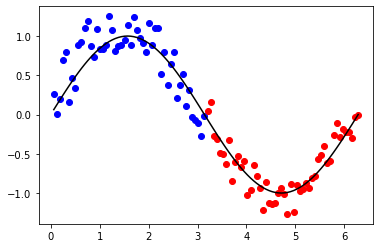

In [219]:
p1 = data.iloc[:50]
p2 = data.iloc[50:]

plt.plot(p1['x'], p1['y'], 'bo')
plt.plot(p2['x'], p2['y'], 'ro')
plt.plot(x, np.sin(x), 'k-')
plt.show()



In [220]:
train = p1
test = p2

In [221]:
r = [0.1, 0.15]

for i in r:

    w = rls(train['x'], train['y'], i)

    y_hat = w[0] + w[1] * test['x']

    mse = np.mean((test['y'] - y_hat)**2)
    print('lambda = ', i, 'MSE = ', mse)



lambda =  0.1 MSE =  0.936562269273229
lambda =  0.15 MSE =  0.9448149301778725


<h5> 1.5.4

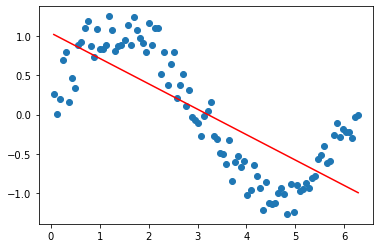

In [222]:
w = rls(data['x'], data['y'], 0.1)
y_hat = w[0] + w[1] * data['x']

plt.plot(data['x'], data['y'], 'o')
plt.plot(data['x'], y_hat, 'r-')
plt.show()


<h3><b>Kalman Filter Extended and Monte Carlo Integration </h3>

In [241]:
#non linear space model

#rk ~ N(0, 0.02)
#q k-1 ~ N(0, 0.01^2)
#xk = xk-1 - 0.01 * sin(xk-1) + qk-1
#yk = 0.5 * sin(2 * xk) + rk
#taylor and non taylor extended kalman filter for this model 

def f(x, dt):
    return x - 0.01 * np.sin(x)

def h(x):
    return 0.5 * np.sin(2 * x)

def Fx(x, dt):
    return 1 - 0.01 * np.cos(x)

def Fv(x, dt):
    return 0

def Hx(x):
    return 2 * np.cos(2 * x)

def Hv(x):
    return 0

def ekf_predict(x, P, Q, R, dt=1):
    x = f(x, dt)
    P = Fx(x, dt) * P * Fx(x, dt) + Fv(x, dt) * Q * Fv(x, dt)
    return (x, P)

def ekf_update(x, P, y, R, dt=1):
    S = Hx(x) * P * Hx(x) + Hv(x) * R * Hv(x)
    K = P * Hx(x) * np.linalg.inv(S)
    x = x + K * (y - h(x))
    P = (np.identity(len(x)) - K * Hx(x)) * P
    return (x, P)

def taylor_ekf_predict(x, P, Q, R, dt=1):
    x = f(x, dt)
    P = Fx(x, dt) * P * Fx(x, dt) + Fv(x, dt) * Q * Fv(x, dt)
    return (x, P)

def taylor_ekf_update(x, P, y, R, dt=1):
    S = Hx(x) * P * Hx(x) + Hv(x) * R * Hv(x)
    K = P * Hx(x) * np.linalg.inv(S)
    x = x + K * (y - h(x))
    P = (np.identity(len(x)) - K * Hx(x)) * P
    return (x, P)

def taylor_ekf(x, P, y, Q, R, dt=1):
    (x, P) = taylor_ekf_predict(x, P, Q, R, dt)
    (x, P) = taylor_ekf_update(x, P, y, Q, R, dt)
    return (x, P)

def ekf(x, P, y, Q, R, dt=1):
    (x, P) = ekf_predict(x, P, Q, R, dt)
    (x, P) = ekf_update(x, P, y, Q, R, dt)
    return (x, P)

def generate_data(N=100):
    x = np.zeros(N)
    y = np.zeros(N)
    x[0] = np.random.normal(0, 0.1)
    y[0] = np.random.normal(h(x[0]), 0.02)
    for k in range(1, N):
        x[k] = np.random.normal(f(x[k-1], dt=1), 0.01)
        y[k] = np.random.normal(h(x[k]), 0.02)
    return (x, y)

def run_ekf(x, y, Q, R):
    N = len(x)
    x_est = np.zeros(N)
    P_est = np.zeros(N)
    x_est[0] = 0.0
    P_est[0] = 1.0
    for k in range(1, N):
        (x_est[k], P_est[k]) = ekf(x_est[k-1], P_est[k-1], y[k], Q, R)
    return (x_est, P_est)

def run_taylor_ekf(x, y, Q, R):
    N = len(x)
    x_est = np.zeros(N)
    P_est = np.zeros(N)
    x_est[0] = 0.0
    P_est[0] = 1.0
    for k in range(1, N):
        (x_est[k], P_est[k]) = taylor_ekf(x_est[k-1], P_est[k-1], y[k], Q, R)
    return (x_est, P_est)

def plot_results(x, y, x_est, P_est, title):
    plt.figure()
    plt.plot(x, 'b-', label='x')
    plt.plot(y, 'g.', label='y')
    plt.plot(x_est, 'r-', label='x_est')
    plt.plot(P_est, 'k-', label='P_est')
    plt.legend()
    plt.title(title)
    plt.show()

(x, y) = generate_data()
(x_est, P_est) = run_ekf(x, y, 0.01, 0.02)
plot_results(x, y, x_est, P_est, 'Extended Kalman Filter')

(x_est, P_est) = run_taylor_ekf(x, y, 0.01, 0.02)
plot_results(x, y, x_est, P_est, 'Taylor Series Extended Kalman Filter')






TypeError: ekf_update() takes from 4 to 5 positional arguments but 6 were given